## $2^η$ Εργαστηριακή Άσκηση Μη επιβλεπόμενη μάθηση
## Σύστημα συστάσεων βασισμένο στο περιεχόμενο
## Σημασιολογική απεικόνιση δεδομένων με χρήση SOM 

## Oμάδα 11
### Καράμπελα Θεοφανία $ $ ΑΜ: <font color='royalblue'>03117081</font> 
### Κουνούδης Δημήτριος $ $  ΑΜ: <font color='royalblue'>03117169</font> 
### Τσακανίκα Χριστίνα $ $ ΑΜ: <font color='royalblue'>03117012</font> 


In [1]:
!pip install --upgrade pip
!pip install --upgrade numpy
!pip install --upgrade pandas
!pip install --upgrade nltk
!pip install --upgrade scikit-learn
!pip install --upgrade joblib

     |████████████████████████████████| 14.8 MB 7.4 MB/s            
     |████████████████████████████████| 9.5 MB 8.2 MB/s            
     |████████████████████████████████| 503 kB 6.6 MB/s            
     |████████████████████████████████| 1.5 MB 1.6 MB/s            
     |████████████████████████████████| 748 kB 7.2 MB/s            
     |████████████████████████████████| 97 kB 4.3 MB/s            
     |████████████████████████████████| 306 kB 6.0 MB/s            
     |████████████████████████████████| 76 kB 4.8 MB/s             
     |████████████████████████████████| 22.2 MB 3.5 MB/s            
     |████████████████████████████████| 25.9 MB 7.2 MB/s             


In [1]:
!pip install --upgrade somoclu
import somoclu
import matplotlib
%matplotlib inline

### Εισαγωγή του Dataset

In [103]:
import pandas as pd

dataset_url = "https://drive.google.com/uc?export=download&id=1-tN5rC1QCgwqL67cvIXdMbtd-Xf9Xqow"
df_data_1 = pd.read_csv(dataset_url, sep='\t',  header=None, quoting=3)

In [104]:
import numpy as np

# Στο επόμενη γραμή βάλτε τον αριθμό της ομάδας στο εργαστήριο των νευρωνικών
team_seed_number = 11

movie_seeds_url = "https://drive.google.com/uc?export=download&id=1-oeMf7BFmiH70XObgC9WOTo-a9cDJZwP"
df_data_2 = pd.read_csv(movie_seeds_url, header=None)

In [105]:
# επιλέγεται 
my_index = df_data_2.iloc[team_seed_number,:].values

titles = df_data_1.iloc[:, [2]].values[my_index] # movie titles (string)
categories = df_data_1.iloc[:, [3]].values[my_index] # movie categories (string)
bins = df_data_1.iloc[:, [4]]
catbins = bins[4].str.split(',', expand=True).values.astype(float)[my_index] # movie categories in binary form (1 feature per category)
summaries =  df_data_1.iloc[:, [5]].values[my_index] # movie summaries (string)
corpus = summaries[:,0].tolist() # list form of summaries
corpus_df = pd.DataFrame(corpus) # dataframe version of corpus

### Εφαρμογή 1. Υλοποίηση συστήματος συστάσεων ταινιών βασισμένο στο περιεχόμενο


### Προεπεξεργασία

In [106]:
import nltk
import numpy as np
from nltk.corpus import stopwords
import string
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
import collections

#download the omportant tokenizers
nltk.download('punkt')
nltk.download('stopwords') 
nltk.download('wordnet') 
nltk.download('rslp')
wordnet_lemmatizer = WordNetLemmatizer()
porter_stemmer = PorterStemmer()

[nltk_data] Downloading package punkt to /home/christine/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/christine/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/christine/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package rslp to /home/christine/nltk_data...
[nltk_data]   Package rslp is already up-to-date!


In [107]:
def thorough_filter(words):
    filtered_words = []
    for word in words:
        pun = []
        for letter in word:
            pun.append(letter in string.punctuation)
        if not all(pun):
            if word != "'s":
                filtered_words.append(word)
    return filtered_words

def preprocess_document(document):
    words = nltk.word_tokenize(document.lower())
    filtered_words = [word for word in words if word not in stopwords.words('english') + list(string.punctuation)]
    filtered_words = thorough_filter(filtered_words)
    stemmed_words = [porter_stemmer.stem(word) for word in filtered_words]
    #cnt = collections.Counter(stemmed_words)
    #stemmed_words = [word for word in filtered_words]
    return stemmed_words

In [8]:
new_titles = [preprocess_document(title[0]) for title in titles]

In [9]:
new_categories = [preprocess_document(cat.replace("/"," ").replace("-"," "))  for cats in categories for cat in cats]

In [32]:
new_summaries = [preprocess_document(summary[0].replace("/"," ").replace("-"," "))  for summary in summaries ]
new_summaries = [[token for token in ncorpus if len(token) > 2] for ncorpus in new_summaries]
new_summaries = [' '.join(sublist) for sublist in new_summaries]

In [108]:
new_corpus = [preprocess_document(corp.replace("/"," ").replace("-"," "))  for corp in corpus ]
token_new_corpus = [[token for token in ncorpus if len(token) > 2] for ncorpus in new_corpus]
new_corpus = [' '.join(sublist) for sublist in token_new_corpus]

### Μετατροπή σε TFIDF

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer

# create sparse tf_idf representation
vectorizer = TfidfVectorizer()
vectorizer.fit(new_corpus)
corpus_tf_idf_plain = vectorizer.transform(new_corpus)

### Υλοποίηση του συστήματος συστάσεων

In [36]:
import scipy as sp
import numpy.linalg as LA

In [37]:
cosine_function = lambda a, b : round(np.inner(a, b)/(LA.norm(a)*LA.norm(b)), 4)

In [63]:
def content_recommender(target_movie, max_recommendations,corpus_type):
    distances = np.zeros(len(corpus))
    movie_vector = corpus_type[target_movie]
    for i in range(len(corpus_type)):
        distances[i] = cosine_function(movie_vector, corpus_type[i])
    indexes = (-distances).argsort()[:max_recommendations+1]
    print("The target movie has id:", target_movie)
    print("title: ", titles[target_movie][0])
    print("synopsis: ", summaries[target_movie][0])
    print("categories: ", categories[target_movie][0])
    print()
    for i in range(1,max_recommendations+1):
        print(i, ". cosine similarity: ", distances[indexes[i]])
        print("id: ", indexes[i], " title: ", titles[indexes[i]][0])
        print("synopsis: ", summaries[indexes[i]][0])
        print("categories: ", categories[indexes[i]][0])
        print()

In [240]:
content_recommender(78, 5, corpus_tf_idf_plain.toarray())

The target movie has id: 78
title:  Champagne
synopsis:  Heiress Betty  draws the ire of her father after using his airplane to fly to her boyfriend  on an ocean liner headed to France. She has dinner alone when her boyfriend becomes seasick and is joined at her table by a mysterious man. Betty receives a telegram from her father who disapprovingly warns her the boyfriend is a golddigger. To prove her father wrong she asks the boyfriend to marry her. A quarrel ensues and the two part company when the ship docks. The boyfriend regrets the fight and goes to Betty to apologize. He finds her entertaining guests, including the mysterious man. Another quarrel between the two is interrupted by the arrival of Betty's father . He tells Betty the family fortune, earned in the "champagne" business, has been wiped out in the stock market. The boyfriend leaves after hearing the news of their fortune. The father sees this as proof the boyfriend is only after money. Betty decides to sell her jewelry 

Παρατηρούμε, ότι με τον μη βελτιστοποιημένο TfidfVectorizer(), αυξημένη ομοιότητα συνιμητόνου παρουσιάζουν ταινίες στις οποίες οι χαρακτήρες έχουν κοινά ονόματα. Οι προτάσεις ταινιών για ID=78, στην οποία η πρωταγωνίστρια ονομαζόταν  Heiress Betty, ήταν ταινίες με τίτλους: Betty Boop's Big Boss, Betty Boop's Birthday Party,Betty in Blunderland,   Betty Boop's Ker-Choo. Επιπλέον, η επιλογή ταινιών δίχως βελτιστοποιημένο vectorizer, ελλοχεύει τον κίνδυνο πρότασης ταινιών με εκτενές synopsis που δεν ταιριάζει απαραίτητα με την πλοκή της ταινίας-στόχου, απλά εμφανίζει ομοιότητα λόγω των αυξημένων αριθμών λέξεών της.

### Bελτιστοποίηση του TfidfVectorizer

Κατά τη διαδικασία της βελτιστοποίησης του Vectorizer, θα τροποποιούμε κάθε φορά τις παραμέτρους $max-df$, όπου θα αγνοούμε λέξεις υψηλής συχνότητας που δεν αφαιρέθηκαν ως stop-words κατά την προεργασία, $min-df$, όπου αφαιρούμε λέξεις που εμφανίζονται εξαιρετικά σπάνια και δεν παίζουν ρόλο στην πλοκή, $ngram range$ και τέλος για την ταχύτερη επεξεργασία θα μειώσουμε την διαστατικότητα με την παράμετρο $max features$.

- $1^η$ Δοκιμή: max_df=0.9, min_df=0.0004, ngram_range=(1,2)

In [101]:
print("Dimensions before optimizing TfidfVectorizer parameters")
print('TF-IDF array shape:', corpus_tf_idf_plain.shape)

print("Dimensions after optimizing TfidfVectorizer parameters")
vectorizer1 = TfidfVectorizer(max_df=0.9, min_df=0.0009, ngram_range=(1,2), stop_words='english')
corpus_tf_idf_optimized_1 = vectorizer2.fit_transform(new_corpus)
print('TF-IDF array shape:', corpus_tf_idf_optimized_1.toarray().shape)

Dimensions before optimizing TfidfVectorizer parameters
TF-IDF array shape: (5000, 35183)
Dimensions after optimizing TfidfVectorizer parameters
TF-IDF array shape: (5000, 7970)


In [102]:
content_recommender(100, 7, corpus_tf_idf_optimized_1.toarray())

The target movie has id: 20
title:  Kshana Kshanam
synopsis:  The film, mainly comprising an unexpected road trip, is the story of a middle class girl  and a thief  brought together under strange circumstances. The movie revolves around the pair chased by an eccentric bank robber,  and the police ([[Rami Reddy . Filming was done at Mudumalai Forests, Tamil Nadu, India. Sridevi's acclaimed performance of an innocent girl stuck in a tight spot, won her awards. She also sang a song  for this film.
categories:  "Thriller",  "Crime Fiction",  "Comedy film",  "Drama",  "Road movie"

1 . cosine similarity:  0.1855
id:  4263  title:  Nikah
synopsis:  The story is about two different classes; Shaan belongs to a middle-class family with great traditional values and Reema is from a rich family. The film portrayed the difficulties of a rich girl adjusting to a middle-class family.
categories:  "Drama"

2 . cosine similarity:  0.1811
id:  2903  title:  Cahill U.S. Marshal
synopsis:   While Cahill  

Έπειτα από την πρώτη δοκιμή βελτιστοποίησης διαπιστώνουμε ότι και για μεγαλύτερο αριθμό προτάσεων (από 5 σε 7) εξακολουθούμε να λαμβάνουμε ταινίες με αρκετά κοντινό περιεχόμενο. Ωστόσο, για ΙD 78  λαμβάνουμε μη ικανοποιητικές προτάσεις, που παρατίθενται ως όμοιες λόγω των κοινών ονομάτων των πρωταγωνιστών.
<br>


- $2^η$ Δοκιμή: max_df=0.5, min_df=0.002, ngram_range=(1,2)

In [ ]:
print("Dimensions before optimizing TfidfVectorizer parameters")
print('TF-IDF array shape:', corpus_tf_idf_plain.shape)

print("Dimensions after optimizing TfidfVectorizer parameters")
vectorizer2 = TfidfVectorizer(max_df=0.5, min_df=0.002, ngram_range=(1,2), stop_words='english')
corpus_tf_idf_optimized_2 = vectorizer2.fit_transform(new_corpus)
print('TF-IDF array shape:', corpus_tf_idf_optimized_2.toarray().shape)

In [69]:
content_recommender(100, 7, corpus_tf_idf_optimized_2.toarray())

The target movie has id: 100
title:  Banzai Runner
synopsis:  A yearly every-man-for-himself car race is staged in the desert, with wealthy motorists driving custom cars at supersonic speed on a deserted highway. During one of these contests, a policeman is killed. With no witnesses, it's up to the cop's brother to see justice is done. He accomplishes this by assuming a false identity and joining the race.
categories:  "Thriller",  "Sports",  "Indie",  "Action/Adventure",  "Action",  "Auto racing"

1 . cosine similarity:  0.2756
id:  4135  title:  Redline
synopsis:  "Sweet JP" - rightfully named for his personality, retro style, and refusal to mount weapons on his racecar - nearly wins the "Yellowline" race against a host of semi-pro alien drivers, most of whom use oversized vehicles with jet engines mounted with guns and missiles, but just before the finish line JP's car is sabotaged by an explosive device placed by his friend and mechanic; Frisbee. In the past, Frisbee and JP were se

Καλά αποτελέσματα για ταινίες με ικανοποιητικές κριτικές, συνεχίζουμε να έχουμε μη ικανοποιητικά αποτελέσματα για ταινίες με μη σχετικές προτάσεις.

- $3^η$ Δοκιμή: max_df=0.4, min_df=0.0015, ngram_range=(1,2)

In [81]:
print("Dimensions before optimizing TfidfVectorizer parameters")
print('TF-IDF array shape:', corpus_tf_idf_plain.shape)

print("Dimensions after optimizing TfidfVectorizer parameters")
vectorizer3 = TfidfVectorizer(max_df=0.4, min_df=0.0015, ngram_range=(1,2), stop_words='english')
corpus_tf_idf_optimized_3 = vectorizer3.fit_transform(new_corpus)
print('TF-IDF array shape:', corpus_tf_idf_optimized_3.toarray().shape)

Dimensions before optimizing TfidfVectorizer parameters
TF-IDF array shape: (5000, 35183)
Dimensions after optimizing TfidfVectorizer parameters
TF-IDF array shape: (5000, 7970)


In [82]:
content_recommender(100, 7, corpus_tf_idf_optimized_3.toarray())

The target movie has id: 100
title:  Banzai Runner
synopsis:  A yearly every-man-for-himself car race is staged in the desert, with wealthy motorists driving custom cars at supersonic speed on a deserted highway. During one of these contests, a policeman is killed. With no witnesses, it's up to the cop's brother to see justice is done. He accomplishes this by assuming a false identity and joining the race.
categories:  "Thriller",  "Sports",  "Indie",  "Action/Adventure",  "Action",  "Auto racing"

1 . cosine similarity:  0.2756
id:  4135  title:  Redline
synopsis:  "Sweet JP" - rightfully named for his personality, retro style, and refusal to mount weapons on his racecar - nearly wins the "Yellowline" race against a host of semi-pro alien drivers, most of whom use oversized vehicles with jet engines mounted with guns and missiles, but just before the finish line JP's car is sabotaged by an explosive device placed by his friend and mechanic; Frisbee. In the past, Frisbee and JP were se

Οι προτάσεις για τις ταινίες στόχους που παρουσίαζαν ικανοποιητικές προτάσεις εξακολουθούν να είναι καλές, ενώ οι ταινίες με μη σχετικές προτάσεις δεν έχουν βελτιωθεί.


- $4^η$ Δοκιμή: max_df=0.001, min_df=0.0009, ngram_range=(1,2)

In [97]:
print("Dimensions before optimizing TfidfVectorizer parameters")
print('TF-IDF array shape:', corpus_tf_idf_plain.shape)

print("Dimensions after optimizing TfidfVectorizer parameters")
vectorizer4 = TfidfVectorizer(max_df=0.001, min_df=0.0009, ngram_range=(1,2), stop_words='english')
corpus_tf_idf_optimized_4 = vectorizer4.fit_transform(new_corpus)
print('TF-IDF array shape:', corpus_tf_idf_optimized_4.toarray().shape)

Dimensions before optimizing TfidfVectorizer parameters
TF-IDF array shape: (5000, 35183)
Dimensions after optimizing TfidfVectorizer parameters
TF-IDF array shape: (5000, 7970)


In [98]:
content_recommender(123, 7, corpus_tf_idf_optimized_4.toarray())

The target movie has id: 20
title:  Kshana Kshanam
synopsis:  The film, mainly comprising an unexpected road trip, is the story of a middle class girl  and a thief  brought together under strange circumstances. The movie revolves around the pair chased by an eccentric bank robber,  and the police ([[Rami Reddy . Filming was done at Mudumalai Forests, Tamil Nadu, India. Sridevi's acclaimed performance of an innocent girl stuck in a tight spot, won her awards. She also sang a song  for this film.
categories:  "Thriller",  "Crime Fiction",  "Comedy film",  "Drama",  "Road movie"

1 . cosine similarity:  0.1855
id:  4263  title:  Nikah
synopsis:  The story is about two different classes; Shaan belongs to a middle-class family with great traditional values and Reema is from a rich family. The film portrayed the difficulties of a rich girl adjusting to a middle-class family.
categories:  "Drama"

2 . cosine similarity:  0.1811
id:  2903  title:  Cahill U.S. Marshal
synopsis:   While Cahill  

Παρατηρούμε ότι μειώνοντας τόσο δραστικά το max_df σε 0.001 οι προτάσεις που λαμβάνουμε ακόμα και για ταινίες για τις οποίες ειχαμε καλά αποτελέσματα, δεν είναι ικανοποιητικές. Συνεπώς, εξάγουμε το συμπέρασμα ότι με παραμέτρους παρόμοιες με αυτές των τριών πρώτων δοκιμών καθώς και με μείωση του min_df, ενδεχομένως να εξάγουμε όλο και πιο ικανοποιητικά αποτελέσματα.


### Bαθιά μάθηση: Δημιουργία corpora με χρήση word embeddings

### Mεταφορά μάθησης εμφυτευμάτων

### Εμφυτεύματα του Gensim-data

In [112]:
!pip install -U gensim
import gensim.downloader
print(list(gensim.downloader.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [135]:
model1 = gensim.downloader.load("glove-twitter-25")
model2 = gensim.downloader.load("glove-twitter-100")

[===-----------------------------------------------] 6.3% 24.5/387.1MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=======-------------------------------------------] 14.0% 54.3/387.1MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=============-------------------------------------] 27.4% 106.1/387.1MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=================---------------------------------] 34.8% 134.8/387.1MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=======================---------------------------] 47.5% 184.1/387.1MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[===========================-----------------------] 54.7% 211.9/387.1MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[==============================--------------------] 61.9% 239.5/387.1MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[==================================----------------] 69.5% 269.1/387.1MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[======================================------------] 77.1% 298.6/387.1MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[==========================================--------] 84.5% 326.9/387.1MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=============================================-----] 91.7% 355.0/387.1MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[==================================================] 100.0% 387.1/387.1MB downloaded


In [124]:
def build_tfw2v(corpus, vectors, embeddings_size, min_df=1, max_df=1.0):
    vectorizer = TfidfVectorizer(min_df=min_df, max_df=max_df)
    vectorizer.fit(corpus)
    tf_idf = vectorizer.transform(corpus).toarray()

    new_corpus = []
    for idx, movie_corpus in enumerate(corpus):
        tf_idf_w2v = np.zeros(embeddings_size)
        tf_idf_acc = 0
        for word in movie_corpus.split(' '):
            col_idx = vectorizer.vocabulary_.get(word)
            if col_idx:
                tf_idf_w = tf_idf[idx][col_idx]
            else:
                tf_idf_w = 0
            tf_idf_acc = tf_idf_acc + tf_idf_w
            try:
                w2v = vectors.get_vector(word)
            except KeyError:
                w2v = np.zeros(embeddings_size)
            tf_idf_w2v = tf_idf_w2v + (tf_idf_w * w2v)
        new_corpus.append(tf_idf_w2v / tf_idf_acc)
    return np.array(new_corpus)

In [133]:
def w2v_content_recommender(target_movie, max_recommendations,corpus_type):
    distances = np.zeros(len(corpus))
    movie_vector = corpus_type[target_movie]
    for i in range(len(corpus_type)):
        distances[i] = cosine_function(movie_vector, corpus_type[i])
    indexes = (-distances).argsort()[:max_recommendations]
    print("The target movie has id:", target_movie)
    print("title: ", titles[target_movie][0])
    print("synopsis: ", summaries[target_movie][0])
    print("categories: ", categories[target_movie][0])
    print()
    for i in range(1,max_recommendations):
        print(i, ". cosine similarity: ", distances[indexes[i]])
        print("id: ", indexes[i], " title: ", titles[indexes[i]][0])
        print("synopsis: ", summaries[indexes[i]][0])
        print("categories: ", categories[indexes[i]][0])
        print()

Θα δοκιμάσουμε αρχικά το κάθε μοντέλο πρώτα με τις αρχικές παραμέτρους min_df=1, max_df=1 και έπειτα με τις βελτιστοποιημένες και θα συγκρίνουμε τις επιδόσεις σε κάθε περίπτωση. 

In [137]:
w2v_corpus_1st = build_tfw2v(new_corpus, model1, 25)
w2v_corpus_1opt = build_tfw2v(new_corpus, model1, 25, 0.0015, 0.9)
w2v_corpus_2st = build_tfw2v(new_corpus, model2, 100)
w2v_corpus_2opt = build_tfw2v(new_corpus, model2, 100, 0.0015, 0.9)

- Mοντέλο "glove-twitter-25" min_df=1, max_df=1 (μη βελτιστοποιημένο)

In [138]:
w2v_content_recommender(78, 7,w2v_corpus_1st)

The target movie has id: 78
title:  Champagne
synopsis:  Heiress Betty  draws the ire of her father after using his airplane to fly to her boyfriend  on an ocean liner headed to France. She has dinner alone when her boyfriend becomes seasick and is joined at her table by a mysterious man. Betty receives a telegram from her father who disapprovingly warns her the boyfriend is a golddigger. To prove her father wrong she asks the boyfriend to marry her. A quarrel ensues and the two part company when the ship docks. The boyfriend regrets the fight and goes to Betty to apologize. He finds her entertaining guests, including the mysterious man. Another quarrel between the two is interrupted by the arrival of Betty's father . He tells Betty the family fortune, earned in the "champagne" business, has been wiped out in the stock market. The boyfriend leaves after hearing the news of their fortune. The father sees this as proof the boyfriend is only after money. Betty decides to sell her jewelry 

- Mοντέλο "glove-twitter-25" min_df=0.0015, max_df=0.9 (βελτιστοποιημένο)

In [139]:
w2v_content_recommender(78, 7, w2v_corpus_1opt)

The target movie has id: 78
title:  Champagne
synopsis:  Heiress Betty  draws the ire of her father after using his airplane to fly to her boyfriend  on an ocean liner headed to France. She has dinner alone when her boyfriend becomes seasick and is joined at her table by a mysterious man. Betty receives a telegram from her father who disapprovingly warns her the boyfriend is a golddigger. To prove her father wrong she asks the boyfriend to marry her. A quarrel ensues and the two part company when the ship docks. The boyfriend regrets the fight and goes to Betty to apologize. He finds her entertaining guests, including the mysterious man. Another quarrel between the two is interrupted by the arrival of Betty's father . He tells Betty the family fortune, earned in the "champagne" business, has been wiped out in the stock market. The boyfriend leaves after hearing the news of their fortune. The father sees this as proof the boyfriend is only after money. Betty decides to sell her jewelry 

- Mοντέλο "glove-twitter-100" min_df=1, max_df=1 (μη βελτιστοποιημένο)

In [140]:
w2v_content_recommender(78, 7,w2v_corpus_2st)

The target movie has id: 78
title:  Champagne
synopsis:  Heiress Betty  draws the ire of her father after using his airplane to fly to her boyfriend  on an ocean liner headed to France. She has dinner alone when her boyfriend becomes seasick and is joined at her table by a mysterious man. Betty receives a telegram from her father who disapprovingly warns her the boyfriend is a golddigger. To prove her father wrong she asks the boyfriend to marry her. A quarrel ensues and the two part company when the ship docks. The boyfriend regrets the fight and goes to Betty to apologize. He finds her entertaining guests, including the mysterious man. Another quarrel between the two is interrupted by the arrival of Betty's father . He tells Betty the family fortune, earned in the "champagne" business, has been wiped out in the stock market. The boyfriend leaves after hearing the news of their fortune. The father sees this as proof the boyfriend is only after money. Betty decides to sell her jewelry 

- Mοντέλο "glove-twitter-100" min_df=0.0015, max_df=0.9 (βελτιστοποιημένο)

In [141]:
w2v_content_recommender(78, 7, w2v_corpus_2opt)

The target movie has id: 78
title:  Champagne
synopsis:  Heiress Betty  draws the ire of her father after using his airplane to fly to her boyfriend  on an ocean liner headed to France. She has dinner alone when her boyfriend becomes seasick and is joined at her table by a mysterious man. Betty receives a telegram from her father who disapprovingly warns her the boyfriend is a golddigger. To prove her father wrong she asks the boyfriend to marry her. A quarrel ensues and the two part company when the ship docks. The boyfriend regrets the fight and goes to Betty to apologize. He finds her entertaining guests, including the mysterious man. Another quarrel between the two is interrupted by the arrival of Betty's father . He tells Betty the family fortune, earned in the "champagne" business, has been wiped out in the stock market. The boyfriend leaves after hearing the news of their fortune. The father sees this as proof the boyfriend is only after money. Betty decides to sell her jewelry 

In [142]:
import joblib

joblib.dump(w2v_corpus_1st, 'w2v_corpus_1st.pkl') 
joblib.dump(w2v_corpus_1opt, 'w2v_corpus_1opt.pkl') 
joblib.dump(w2v_corpus_2st, 'w2v_corpus_2st.pkl') 
joblib.dump(w2v_corpus_2opt, 'w2v_corpus_2opt.pkl') 

#joblib.dump(tf_idf, 'tf_idf.pkl') 
#joblib.dump(vector2, 'vector2.pkl') 

['w2v_corpus_2opt.pkl']

In [53]:
w2v_corpus_1st = joblib.load('w2v_corpus_1st.pkl') 
w2v_corpus_1opt = joblib.load('w2v_corpus_1opt.pkl') 
w2v_corpus_2st = joblib.load('w2v_corpus_2st.pkl') 
w2v_corpus_2opt = joblib.load('w2v_corpus_2opt.pkl') 
#w2vnew_corpus = joblib.load('corpus_tf_idf.pkl')
#tf_idf = joblib.load('tf_idf.pkl')
#vector2 = joblib.load('vector2.pkl')

### Ανάλυση αποτελεσμάτων

#### Σύστημα συστάσεων βασισμένο μόνο στο tfidf

- Η διαδικασία της προεπεξεργασίας εκκινεί μετατρέποντας όλα τα γράμματα κάθε λέξης σε πεζά, αφού ο υπολογιστής θεωρεί τα κεφαλαία και τα μικρά ως διαφορετικούς χαρακτήρες. Εν συνεχεία, αφαιρούμε απο το corpus τα σημεία στίξης και τα stopwords. Αυτές οι συχνά χρησιμοποιούμενες λέξεις δεν προσφέρουν ιδιαίτερη σημασιολογική αξία στο κείμενο και ενδεχομένως να καθυστερούν και να δυσχεραίνουν την πρόταση σχετικών ταινιών. Επιπλέον αφαιρούμε τους χαρακτήρες "/", "-" και τα strings " 's", που δεν είχαν νοημα να παραμένουν ως tokens. Τέλος, για να αποφύγουμε το πρόβλημα της προσθήκης επιπλέον διάστασης στην αναπαράσταση λέξεων με παρόμοιο σημασιολογικό περιεχόμενο, επιλέγουμε την τεχνική του stemming (έναντι του lemmatization), διότι μας μειώνει πιο αποτελεσματικά τις διαστάσεις των δεδομένων μας και ευνοεί την οικονομία χρόνου.
<br>

- Κατά τη βελτιστοποίηση της TfidfVectorizer επιλέγοντας αρχικά παραμέτρους max_df=0.9, min_df=0.0004, ngram_range=(1,2), μειώνουμε σταδιακά τα max_fd & min_df και ελέγχoυμε τι προτάσεις ταινιών έχουμε λάβει. Παρατηρούμε ότι για τα ζεύγη max_df=0.9 & min_df=0.0004, max_df=0.5 & min_df=0.002, max_df=0.4 & min_df=0.0015,λαμβάνουμε παρόμοια αποτελέσματα χωρίς βεβαια να βελτιώνονται οι προτάσεις για ταινίες με μη σχετικά recommendations. Παράλληλα, θέτοντας πολύ μικρές τιμές στο max_df, χειροτερεύουν οι προτάσεις ταινιών.
<br>

- Cherry picking IDs: 100, 123, 167 όπου τόσο οι πλοκές, όσο και οι κατηγορίες των ταινιών είναι σχετικές μεταξύ τους και άρα ο recommender έχει κάνει αξιόλογες προτάσεις.
<br>

- Nir-picking: 1, 24, 78 όπου δίνουν την εντύπωση τυχαίων προτάσεων ταινιών στην εκάστοτε ταινία στόχο.
<br>

- Ως γενικότερο σχόλιο θα μπορούσαμε να παραθέσουμε ότι ο TF-IDF recommender, στο dataset μας, κάνει καλές προτάσεις για ταινίες πολύ συγκεκριμένων κατηγοριών (πχ, rally races ID:100 ), ενώ παρουσιάζει μη ικανοποιητικά αποτελέσματα για ταινίες στις οποίες οι χαρακτήρες έχουν κοινά ονόματα παραθέτοντας τες ως όμοιες. Οι προτάσεις ταινιών για ID=78, στην οποία η πρωταγωνίστρια ονομαζόταν Heiress Betty, ήταν ταινίες με τίτλους: Betty Boop's Big Boss, Betty Boop's Birthday Party,Betty in Blunderland, Betty Boop's Ker-Choo. Επιπλέον, η πρόταση ταινιών με εκτενές synopsis που δεν ταιριάζει απαραίτητα με την πλοκή της ταινίας-στόχου, απλά εμφανίζει ομοιότητα λόγω των αυξημένων αριθμών λέξεών της, είναι ένα σύνηθες φαινόμενο στον recommender αυτο. Οι προτάσεις ταινιών άρα στην περίπτωση αυτή δεν είναι ιδιαίτερα επιτυχείς.
<br>
- To TF-IDF απιδίδει βάρος σε κάθε λέξη σύμφωνα με τη συχνότητα εμφάνισης ενός όρου σε ένα document και του λογαρίθμου του αριθμού των documents προς τον αριθμό των κειμένων στους οποίους εμφανίζεται η κάθε λέξη. 
<br> Η βασική της μετρική επομένως αποδίδει βάρη στους πιο περιγραφικούς όρους ενός document και υπολογίζει εύκολα την ομοιότητα συνημιτόνου μεταξύ δύο documents. <br>
Ωστόσο, η μέθοδος αυτή απαιτεί πολύ χρόνο ιδίως όταν εργαζόμαστε σε μεγάλα corpus. Βασιζόμενη στο Bag of Wοrds μοντέλο, θεωρεί ότι διαφορετικές λέξεις έχουν διαφορετική απόδειξη ομοιότητας και αγνοεί την σημασιολογική ομοιότητα μεταξύ των λέξεων.

#### Σύγκριση και σχολιασμός με recommenders βασισμένων στο Word2Vec

- Παρατηρούμε πως οι recommenders που βασίζονται σε μεταφορά μάθησης και εμφυτεύματα παρουσιάζουν πολύ καλά αποτελέσματα και για ταινίες στόχους, για τις οποίες είχαμε καλές προτάσεις (IDs: 100, 123, 167) καθώς επίσης και για τις ταινίες-στόχους, όπου δεν είχαμε συναφείς με το περιεχόμενο προτάσεις (IDs 1,24,78), αντιμετωπίζοντας επιτέλους το πρόβλημα πρότασης ταινιών με ονόματα πρωταγωνιστών κοινά με την ταινία στόχο. Επιπλέον, απαλείφθηκαν και οι προτάσεις ταινιών με εκτενές synopsis που θεωρούταν σχετικό μόνο και μόνο για τον αυξημένο αριθμό λέξεών τους. Tα αποτελέσματα των recommenders αυτών εξακολουθούσαν να είναι σχετικά και για αυξημένο αριθμό max recommendations.
<br>

- Παρατηρούμε πως οι ταινίες που προτείνονται από τους word2vec recommenders είναι πάντα σχετικές με την ταινία στόχο, εμφανίζοντας πολύ υψηλό cosine similarity. To μόνο που αλλάζει βελτιστοποιοώντας τις παραμέτρους είναι η σειρά με την οποία προτείνονται οι ταινίες, ούτως ώστε η προτεραιότητα παρουσίασής τους να είναι πιο συμβατή με την ταινία στόχο. Όσο αφορά την ανάλυση των ποσοτικών χαρακτηριστικών, παρατηρούμε ότι όταν αυξήθηκε ο αριθμός των embeddings από 25 σε 100, η λήψη του δεύτερου μοντέλου καθυστέρησε ελάχιστα παραπάνω, ενώ η εξαγωγή των αποτελεσμάτων με την w2v_content_recommender ήταν ίδια χρονικά με αυτη του μοντέλου με τα λιγότερα embeddings.

### Εφαρμογή 2. Τοπολογική και σημασιολογική απεικόνιση της ταινιών με χρήση SOM

In [143]:
my_best_corpus = w2v_corpus_2opt

In [144]:
mycorpus = np.zeros((my_best_corpus.shape[0], my_best_corpus.shape[1]+catbins.shape[1]))
for i in range(len(my_best_corpus)):
    mycorpus[i] = np.append(my_best_corpus[i],catbins[i])

In [145]:
def build_final_set(mycorpus, doc_limit = 5000, tf_idf_only=False):
    # convert sparse tf_idf to dense tf_idf representation
    #dense_tf_idf = mycorpus.toarray()[0:doc_limit,:]
    dense_tf_idf = mycorpus[0:doc_limit,:]
    if tf_idf_only:
        # use only tf_idf
        final_set = dense_tf_idf
    else:
        # append the binary categories features horizontaly to the (dense) tf_idf features
        final_set = np.hstack((dense_tf_idf, catbins[0:doc_limit,:]))
    # η somoclu θέλει δεδομ΄ένα σε float32
    return np.array(final_set, dtype=np.float32)

In [146]:
final_set = build_final_set(mycorpus)
print(final_set.shape)
print(type(final_set))

(5000, 744)
<class 'numpy.ndarray'>


In [192]:
n_rows, n_columns = 10, 10
som = somoclu.Somoclu(n_columns, n_rows, compactsupport=False)
%time som.train(final_set[:5000,:], epochs=100)

CPU times: user 1min 56s, sys: 0 ns, total: 1min 56s
Wall time: 10.8 s


### Βest matching units

In [193]:
bmus = som.bmus
print(bmus.shape)
ubmus, indices = np.unique(bmus, return_inverse=True, axis=0)
print("The number of the unique best matching units: ",len(ubmus))
#print(indices)

(5000, 2)
The number of the unique best matching units:  98


### Oμαδοποίηση

### Ομαδοποίηση με unified distance matrix (U-matrix):

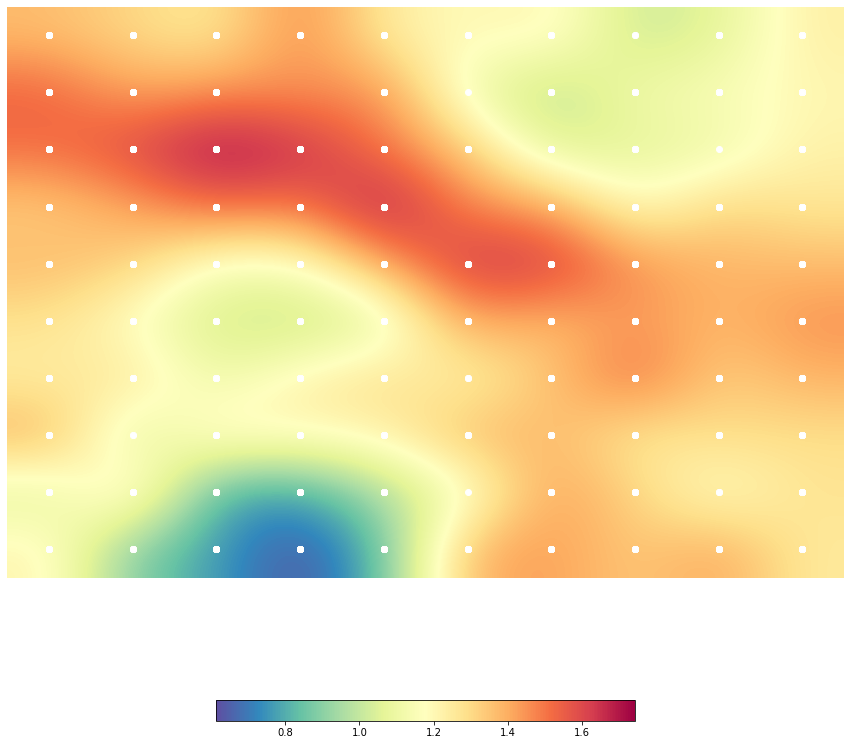

<module 'matplotlib.pyplot' from '/home/christine/notebook/jupyterenv/lib/python3.6/site-packages/matplotlib/pyplot.py'>

In [194]:
labels = range(len(mycorpus))
som.view_umatrix(bestmatches=True, colorbar=True, 
                 figsize=(15, 15))

### Σημασιολογική Ερμηνεία των clusters

### Oμαδοποίηση χρησιμοποιώντας αλγόριθμο ομαδοποίησης

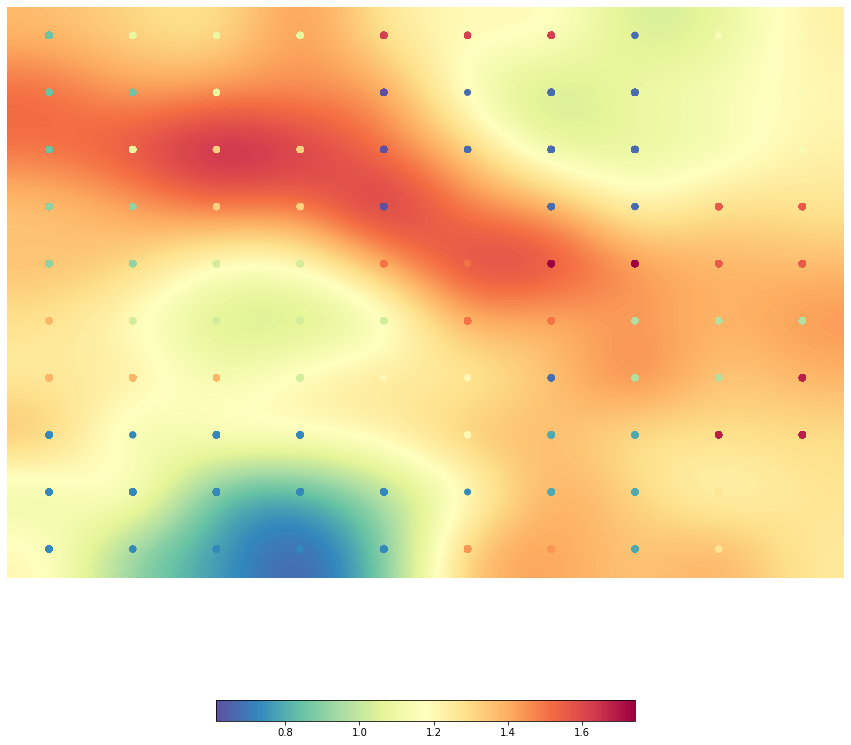

[[ 4  8  8  8 17 17 17  1  9  9]
 [ 4  4  8  1  0  1  1  1  9  9]
 [ 4  8 12 12  0  1  1  1  9  9]
 [ 5  5 12 12  0  0  1  1 16 16]
 [ 5  5  7  7 15 15 19 19 16 16]
 [13  7  7  7  7 15 15  6  6  6]
 [13 13 13  7 10 10  1  6  6 18]
 [ 2  2  2  2 10 10  3  3 18 18]
 [ 2  2  2  2  2  2  3  3 11 11]
 [ 2  2  2  2  2 14 14  3 11 11]]
(5000, 2)
The number of the unique best matching units:  98


In [195]:
from sklearn.cluster import KMeans
algorithm = KMeans(n_clusters=20)
som.cluster(algorithm=algorithm)
som.view_umatrix(bestmatches=True, colorbar=True, 
                 figsize=(15, 15))

print(som.clusters)
bmus = som.bmus
print(bmus.shape)
ubmus, indices = np.unique(bmus, return_inverse=True, axis=0)
print("The number of the unique best matching units: ",len(ubmus))
#print(indices)

In [196]:
import operator

def print_categories_stats(ids):
    total_categories = []
    for i in ids:
        L =  categories[i][0].replace('"', "").split(',')
        L = [j.strip() for j in L]
        total_categories.extend(L)
    (unique, counts) = np.unique(total_categories, return_counts=True)
    #for count in counts: print(int(count))
    #countss = [int(count) for count in counts]
    frequencies  = dict(zip(unique, counts) )
    frequencies = dict( sorted(frequencies.items(), key=operator.itemgetter(1),reverse=True))

    #sorted_array = frequencies[np.argsort(frequencies[:, 1])]
    return frequencies   

In [197]:
def print_cluster_neurons_movies_report(cluster_number):
    A,B = np.where(som.clusters==cluster_number)
    inds = np.column_stack((A,B))
    neuron_indices = []

    for i in range(len(inds)):
        for ubmu in ubmus:
            if inds[i][0] == ubmu[0] and inds[i][1]==ubmu[1]:
                neuron_indices.append(ubmu[1]*som.umatrix.shape[0] + ubmu[0]) 
                break
    #     for j, bmu in enumerate(bmus):
    #         if bmu[0] == inds[i][0] and bmu[1]==inds[i][1] and inds[i] in ubmus:
        #if inds[i] in ubmus:
            #print(ubmus[inds[i][0]][inds[i][1]])
            #neuron_indices.append(inds[i][0]*10 + inds[i][1]) 
    
#     for ubmu in ubmus:
#         if bmu[0] == ubmu[0] and bmu[1] == ubmu[1]:
#             neuron_indices.append(ubmu[0] + (ubmu[1] + 1) * som.umatrix.shape[0]) 
    
    #print(neuron_indices)
    return neuron_indices

In [198]:
def neuron_movies_report(neurons):
    movies = []
    for j in neurons:
        movies.extend(np.where(indices==j)[0])
    return print_categories_stats(movies)
        

In [202]:
neuron_movies_report(print_cluster_neurons_movies_report(13))

{'Comedy': 182,
 'Drama': 178,
 'Comedy-drama': 69,
 'Indie': 63,
 'Black comedy': 32,
 'World cinema': 21,
 'Coming of age': 17,
 'Crime Fiction': 16,
 'Satire': 14,
 'Family Drama': 12,
 'Buddy film': 9,
 'Ensemble Film': 9,
 'Film adaptation': 9,
 'Period piece': 9,
 'Family Film': 8,
 'Musical': 8,
 'Black-and-white': 7,
 'Road movie': 7,
 'Teen': 7,
 'Thriller': 7,
 'Action': 6,
 'Cult': 6,
 'Fantasy': 6,
 'Parody': 6,
 'Tragicomedy': 6,
 'Action/Adventure': 5,
 'Fantasy Comedy': 5,
 'Political cinema': 5,
 'Science Fiction': 5,
 'War film': 5,
 'Adventure': 4,
 'Chinese Movies': 4,
 'Crime Comedy': 4,
 'Romantic comedy': 4,
 'Sex comedy': 4,
 'Sports': 4,
 'Comedy of manners': 3,
 'Music': 3,
 'Mystery': 3,
 'Romance Film': 3,
 'Short Film': 3,
 'Slice of life story': 3,
 'Absurdism': 2,
 'Addiction Drama': 2,
 'Animation': 2,
 'Art film': 2,
 'Comedy film': 2,
 'Domestic Comedy': 2,
 'Experimental film': 2,
 'Gangster Film': 2,
 'Japanese Movies': 2,
 'Marriage Drama': 2,
 'Medi

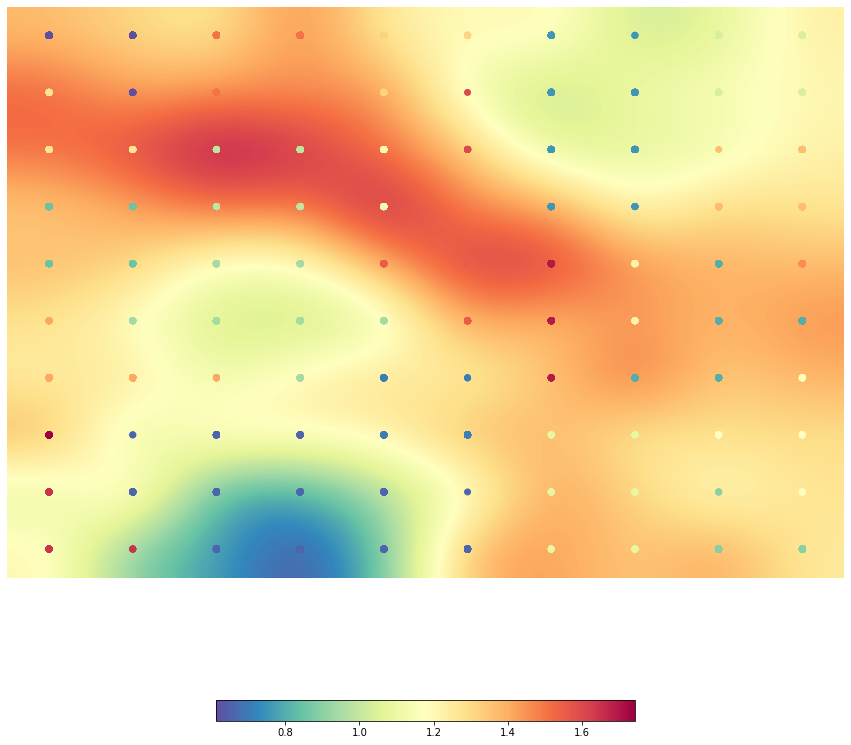

[[ 0  0 19 19 15 15  3  3  9  9]
 [14  0 19 21 15 21  3  3  9  9]
 [14 14  8  8 11 21  3  3 16 16]
 [ 5  5  8  8 11 21  3  3 16 16]
 [ 5  5  7  7 20 20 23 13  4 18]
 [17  7  7  7  7 20 23 13  4  4]
 [17 17 17  7  2  2 23  4  4 12]
 [24  1  1  1  2  2 10 10 12 12]
 [22  1  1  1  1  1 10 10  6 12]
 [22 22  1  1  1  1 10 10  6  6]]
(5000, 2)
The number of the unique best matching units:  98


In [204]:
algorithm = KMeans(n_clusters=25)
som.cluster(algorithm=algorithm)
som.view_umatrix(bestmatches=True, colorbar=True, 
                 figsize=(15, 15))
print(som.clusters)

bmus = som.bmus
print(bmus.shape)
ubmus, indices = np.unique(bmus, return_inverse=True, axis=0)
print("The number of the unique best matching units: ",len(ubmus))
#print(indices)

In [ ]:
neuron_movies_report(print_cluster_neurons_movies_report(3))

### Τελικός χάρτης SOM

CPU times: user 21min 21s, sys: 770 ms, total: 21min 22s
Wall time: 1min 58s


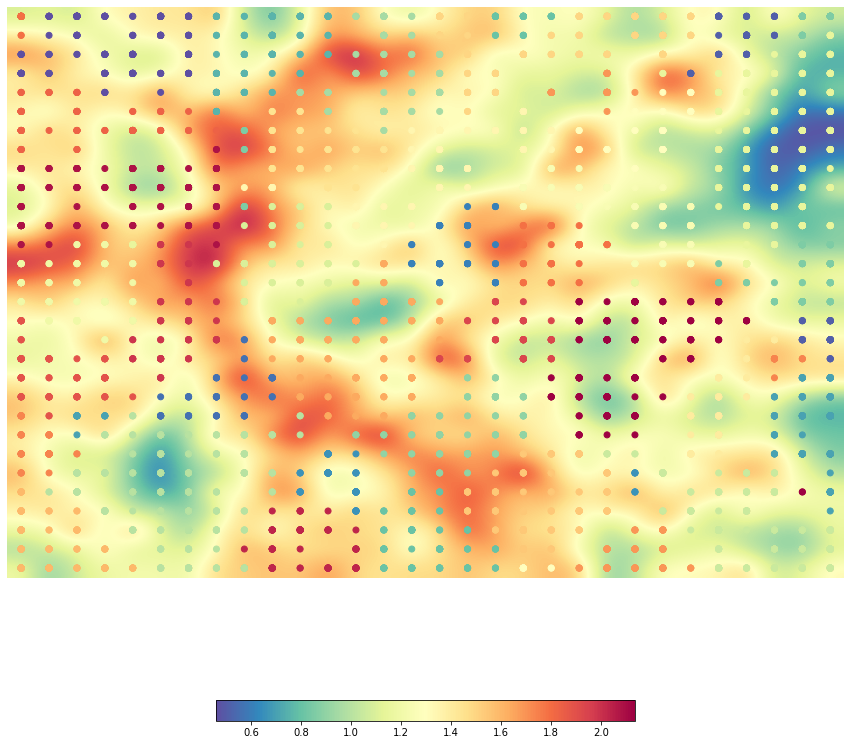

[[27  0  0  0  0  0  0  6  6  6  6  6 10 10 10 21 21  7  7  7 21 21 21 21
  21  1  1  1  8  8]
 [27  0  0  0  0  0  0  6  6  6  6  6 10 10 10 21 21  7  7 21 21 21 21 21
  21  1  1  1  8 14]
 [ 0  0  0  0  0  0  0  6  6  6  6  6 10 10 10 10 21 21 21 21 21 21 21 21
  14  1  1 14 14 14]
 [ 0  0  0  0  0  0  0  6  6  6  6 10 10 10 10 10 21 21 21 25 25 25 25 14
   1 14 14 14 14 14]
 [28 28 28  0  0  0  6  6  6  6 10 10 10 10 10 10 21 21 18 25 25 25 25 17
  17 14 14 14 14 14]
 [28 28 28 28 28 28 28  6  6 20 20 10 10 10 10 10 21 18 18 18 25 25 17 17
  17 14 14 14 14 14]
 [28 28 28 28 28 28 28 28  8 20 20 20 20 10 18 18 18 18 18 18 17 17 17 17
  17 14 14 14 14 14]
 [28 28 28 28 33 33 33 33  8 20 20 20 20 20 18 18 18 18 18 18 17 17 17 17
  17 14 14 14 14 14]
 [33 33 33 33 33 33 33 33  8 20 20 20 20 20 18 18 18 18 18 16 16 16 17 17
  14 14 14 14 14 14]
 [33 33 33 33 33 33 33 33 18 18 20 20 20 20 18 18 18 18 16 16 16 16 16 16
  16 14 14 14 14 14]
 [33 33 33 33 33 33 33 33  8 13 13 13 18 18 18 18 

In [215]:
n_rows, n_columns = 30, 30
som = somoclu.Somoclu(n_columns, n_rows, compactsupport=False)
%time som.train(final_set[:5000,:], epochs=100)

algorithm = KMeans(n_clusters=35)
som.cluster(algorithm=algorithm)
som.view_umatrix(bestmatches=True, colorbar=True, 
                 figsize=(15, 15))
print(som.clusters)

bmus = som.bmus
print(bmus.shape)
ubmus, indices = np.unique(bmus, return_inverse=True, axis=0)
print("The number of the unique best matching units: ",len(ubmus))

In [229]:
from itertools import islice

def nodes_in_every_cluster(k):
    total_nodes = []
    for i in range(k):
        freqs = neuron_movies_report(print_cluster_neurons_movies_report(i))
        total_nodes.append(sum(freqs.values()))
        print("Total nodes of cluster", i, "are: ",sum(freqs.values()))
        print("Top 5 categories of cluster", i, "are: ", list(freqs.items())[:5])
        print("Bottom 5 categories of cluster", i, "are: ", list(freqs.items())[-5:])
        print()

In [230]:
nodes_in_every_cluster(35)

Total nodes of cluster 0 are:  650
Top 5 categories of cluster 0 are:  [('Comedy', 146), ('Drama', 77), ('Romance Film', 51), ('Romantic comedy', 37), ('World cinema', 36)]
Bottom 5 categories of cluster 0 are:  [('Stand-up comedy', 1), ('Superhero', 1), ('Superhero movie', 1), ('Western', 1), ('Workplace Comedy', 1)]

Total nodes of cluster 1 are:  93
Top 5 categories of cluster 1 are:  [('Drama', 44), ('Comedy film', 31), ('Black comedy', 3), ('Family Film', 3), ('Music', 2)]
Bottom 5 categories of cluster 1 are:  [('Erotic Drama', 1), ('Filipino Movies', 1), ('Juvenile Delinquency Film', 1), ('Romantic drama', 1), ('Silent film', 1)]

Total nodes of cluster 2 are:  287
Top 5 categories of cluster 2 are:  [('Comedy', 47), ('Parody', 34), ('Action', 20), ('Action/Adventure', 19), ('Satire', 11)]
Bottom 5 categories of cluster 2 are:  [('Superhero movie', 1), ('Surrealism', 1), ('Swashbuckler films', 1), ('Time travel', 1), ('Zombie Film', 1)]

Total nodes of cluster 3 are:  365
Top 5 

1. Παραπάνω, παραθέτουμε τον συνολικό αριθμό κόμβων σε κάθε cluster, καθώς και τις 5 πιο συχνές σε εμφανίσεις κατηγορίες του κάθε cluster. Σύμφωνα με τα παραπάνω, πολύ συχνές κατηγορίες είναι οι: Comedy, Drama, Horror, Thriller, ενώ οι σπανιότερες κατηγορίες είναι οι: Space western, Political thriller, Television movie.

2. Στον τελικό χάρτη SOM που τυπώσαμε παραπάνω, παρατηρούμε ότι τα clusters 2 και 12 εμφανίζονται απομακρυσμένα, Το cluster 12 βρίσκεται στην κάτω δεξιά γωνία και δεν συνορεύει πουθενά με το 2. Όπως αποδίδεται, οι πιο συχνές κατηγορίες για το cluster 2 είναι 'Comedy', 'Parody', 'Action', 'Action/Adventure', 'Satire', ενώ για το cluster 12 οι συχνότερες κατηγορίες είναι 'Drama', 'Family Drama', 'Film adaptation', 'Period piece', 'Biography'. Συνεπώς, συμπεραίνουμε ότι τα clusters αυτά διαφέρουν αρκετά θεματικά γι'αυτό άλλωστε τοποθετούνται σε αρκετά απομακρυσμένα σημεία στο χάρτη. Αντίστοιχο παράδειγμα αποτελεί και το ζεύγος των clusters 8 και 23, με το πρώτο να παρουσιάζει ως συχνότερες κατηγορίες τις 'Horror', 'Drama', 'Thriller', 'Short Film', 'Slasher', ενώ το cluster 23  'Romance Film', 'Comedy', 'Romantic comedy', 'Romantic drama'. Και σε αυτήν την περίπτωση το περιεχόμενο των ταινιών διαφέρει.

3. Παρατηρούμε ότι τα clusters 20 και 18 που αποδίδονται δίπλα-δίπλα στον χάρτη έχουν κοινό περιεχόμενο ταινιών, αφού οι πιο συχνές κατηγορίες σε αυτά είναι 'Action/Adventure', 'Horror', 'Action', 'Thriller' και 'Drama', 'Action', 'Thriller', 'Crime Fiction', 'Adventure' αντίστοιχα. Τα clusters 3, 30 επίσης βρίσκονται κοντά στον som χάρτη και εμφανίζουν κοινές κατηγορίες 'Drama', 'Action', 'Action/Adventure', 'Crime Fiction'. Τα πιο χαρακτηριστικά παραδείγματα είναι τα 0, 28 όπου οι 5 πιο συχνές κατηγορίες είναι ίδιες και για τα δύο clusters.

Τα clusters αποτελούν ομάδες νευρώνων, και κατ' επέκταση σύνολα ταινιών, με κοινά χαρακτηριστικά. Τυπώνοντας τα αποτελέσματα για κάθε ένα cluster με τις 3 συναρτήσεις που ζητήθηκε να υλοποιήσουμε, διαπιστώνουμε πως κάθε cluster έχει ένα συγκεκριμένο χαρακτηριστικό, δηλαδή η πλειονότητα των ταινιών είναι μιας συγκεκριμένης κατηγορίας ή οι κατηγορίες του cluster ειναι σχετικές μεταξύ τους. Στην περιπτωσή μας, όπου το cluster 33 συγκεντρώνει τους περισσότερους κόμβους, 1073 το αριθμό, οι ταινίες χαρακτηρίζονται ως κωμωδίες, δράματα και ρομαντικές. Πάρα ταύτα, υπάρχουν μεγάλα και μικρά clusters που δεν έχουν σαφή χαρακτηριστικά.
<br>
Ως cluster με σαφή χαρακτηριστικά χαρακτηρίζεται αυτό το οποίο περιέχει ταινίες με σχετικές κατηγορίες. Ένα τέτοιο cluster είναι για εμάς το 2 όπου περιέχει τις κατηγορίες  [('Comedy', 47), ('Parody', 34), ('Action', 20), ('Action/Adventure', 19), ('Satire', 11)] καθώς επίσης και το  4  [('Horror', 56), ('Thriller', 41), ('Science Fiction', 26), ('Supernatural', 17), ('Action', 16)].
<br>
Στην αντίθετη περίπτωση, cluster με μη σαφή χαρακτηριστικά χαρακτηρίζεται εκείνο όπου οι πλειονότητα των ταινιών συγκεντρώνεται σε μια κατηγορία και δεν υπάρχει κάποια επιπλέον δευτερεύουσα κατηγορία με υψηλή συχνότητα, που να "συνδέει" τις ταινίες του cluster μεταξύ τους. Παράδειγμα τέτοιου μικρού cluster αποτελεί για εμάς το 12 όπου υπάρχει υπερσυγκέντρωση 'Drama' και ελάχιστες ταινίες άλλων κατηγοριών  (Total nodes of cluster 12 are:  95
Top 5 categories of cluster 12 are:  [('Drama', 63), ('Family Drama', 5), ('Film adaptation', 4), ('Period piece', 3), ('Biography', 2)]), ενώ αντίστοιχο παράδειγμα μεγαλύτερου cluster είναι το 17 (Total nodes of cluster 17 are:  278
Top 5 categories of cluster 17 are:  [('Drama', 150), ('Period piece', 14), ('Biographical film', 9), ('Docudrama', 8), ('Indie', 7)]).
<br>
Παρά την αυξημένη ακρίβεια που εμφανίζει ο χάρτης μας, πράγματι, η τοποθέτηση σε δύο διαστάσεις που να σέβεται την απόλυτη τοπολογία δεν είναι εφικτή. Αυτό μπορεί να επιβεβαιωθεί με τα clusters 21 και 22 τα οποία δεν συνορεύουν στον χάρτη και είναι σχετικά απομακρυσμένα, ωστόσο εμφανίζουν αρκετά κοινό περιεχόμενο ταινιών και συγκεκριμένα για το 21 'Drama', 'World cinema', 'War film', 'Adventure', 'Crime Fiction' και το 22 'Drama', 'War film', 'Crime Fiction', 'Action', 'Adventure'. Όπως αναλύθηκε, το παραπάνω συμβαίνει διότι δεν υπάρχει κάποια απόλυτη εξ ορισμού τοπολογία για τα κινηματογραφικά είδη ακόμα και σε πολλές διαστάσεις καθώς επίσης επειδή πραγματοποιείται μείωση διαστατικότητας.
<br>
Τέλος, το cluster 33 δείχνει να έχει περισσότερο ενδιαφέρον για το dataset μας διότι συγκαταλλέγει τις τρεις πιο κοινότυπες κατηγορίες ταινιών (comedy, drama, romantic), αντιπροσωπεύοντας έτσι καλύτερα τη βάση δεδομένων των ταινιών μας. Αντίστοιχα παραδείγματα clusters που παρουσιάζουν ενδιαφέρον για το dataset μας είναι τα 0 και 28.